<a href="https://colab.research.google.com/github/kworathur/CV-Capstone/blob/main/brain_tumor_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload() # Upload your kaggle API Key

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"keshavworathur","key":"525a7f6c30bb7e288d40bf6600c4074c"}'}

# Install Python packages and download dataset

In [2]:
!pip install tensorflow
!pip install mat73
!pip install hdf5storage
!pip install opencv-python
!pip install gdown
!pip install -q kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

!chmod 600 /root/.kaggle/kaggle.json

# Create the directories for original data
!rm -rf ./dataset/
!kaggle datasets download -d ashkhagan/figshare-brain-tumor-dataset
!unzip figshare-brain-tumor-dataset.zip > /dev/null



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 1.5 MB/s eta 0:00:00
100% 839M/839M [00:11<00:00, 81.7MB/s]
100% 839M/839M [00:11<00:00, 79.9MB/s]


In [3]:
# Download helper script hosted in google drive
!gdown https://drive.google.com/uc?id=1RFcC9qAiBl5Bv07wRD6HGRk_BBi1lU98

Downloading...
From: https://drive.google.com/uc?id=1RFcC9qAiBl5Bv07wRD6HGRk_BBi1lU98
To: /content/matlab_to_numpy.py
100% 3.06k/3.06k [00:00<00:00, 15.5MB/s]


In [4]:
%run -i 'matlab_to_numpy.py' ./dataset/
%reset

[3064/3064] images loaded: 100.0 %
labels: (3064,)
images: (3064, 512, 512)
masks: (3064, 512, 512)
labels.npy, images.npy, masks.npy, patient_ids saved in ./dataset/
Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [5]:
import gc
gc.collect()

0

# Import Python Modules

In [6]:
import os
from PIL import Image
from mat73 import loadmat

import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# to perform subject-wise cross validation
from sklearn.model_selection import GroupKFold
import cv2

# Data Visualization



*   Adapted from https://github.com/guillaumefrd/brain-tumor-mri-dataset/tree/master
*   Class distribution
*   2D images with tumor slices
*   Different types of brain tumors: glioma, meningioma, pituitary





In [7]:
integer_to_class = {'1': 'meningioma (1)', '2': 'glioma (2)', '3': 'pituitary tumor (3)'}

## Load images, masks and labels

In [8]:
labels = np.load('./dataset/labels.npy')
images = np.load('./dataset/images.npy', mmap_mode='r')
masks = np.load('./dataset/masks.npy', mmap_mode='r')
patient_ids = np.load('./dataset/patient_ids.npy').flatten()
file_paths = np.load('./dataset/file_paths.npy')

## Number of examples per class

number of meningioma (1): 708
number of glioma (2): 1426
number of pituitary tumor (3): 930


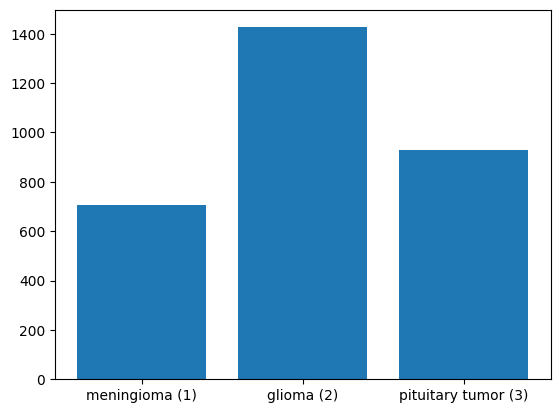

In [9]:
classes, counts = np.unique(labels, return_counts=True)
plt.bar(classes, counts,
        tick_label=['meningioma (1)', 'glioma (2)', 'pituitary tumor (3)'])

for i, idx in enumerate(classes):
    print('number of {}: {}'.format(integer_to_class[str(idx)], counts[i]))

## Visualize slices with tumor masks

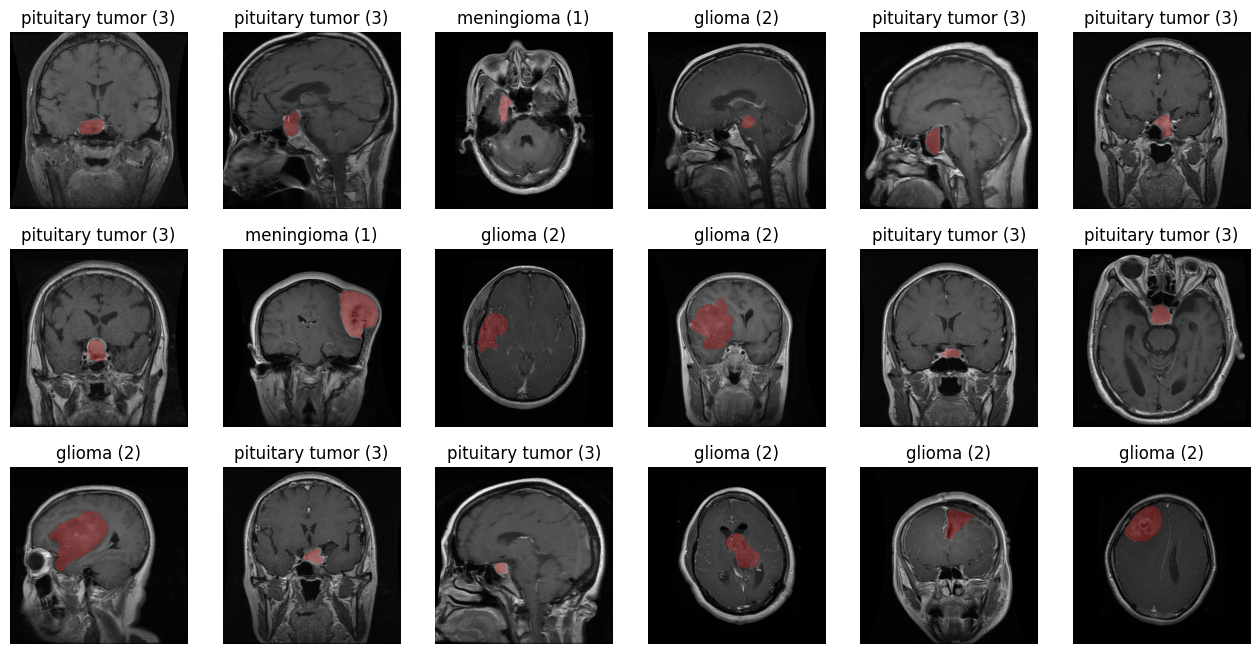

In [10]:
plt.figure(figsize=(16, 8))
for i, idx in enumerate(np.random.randint(images.shape[0], size=18), start=1):
    plt.subplot(3, 6, i)
    plt.imshow(images[idx], cmap='gray')

    # set black pixel as transparent for the mask
    mask = np.ma.masked_where(masks[idx] == False, masks[idx])
    plt.imshow(mask, alpha=0.3, cmap='Set1')

    plt.title(integer_to_class[str(labels[idx])])
    plt.axis('off')

## Crop the images to the tumor region

In [11]:
def get_bounding_box(mask):
    """
    Return the bounding box of a mask image.
    """
    xmin, ymin, xmax, ymax = 0, 0, 0, 0

    for row in range(mask.shape[0]):
        if mask[row, :].max() != 0:
            ymin = row
            break

    for row in range(mask.shape[0] - 1, -1, -1):
        if mask[row, :].max() != 0:
            ymax = row
            break

    for col in range(mask.shape[1]):
        if mask[:, col].max() != 0:
            xmin = col
            break

    for col in range(mask.shape[1] - 1, -1, -1):
        if mask[:, col].max() != 0:
            xmax = col
            break

    return xmin, ymin, xmax, ymax


def crop_to_bbox(image, bbox, crop_margin=10):
    """
    Crop an image to the bounding by forcing a squared image as output.
    """
    x1, y1, x2, y2 =  bbox

    # force a squared image
    max_width_height = np.maximum(y2 - y1, x2 - x1)
    y2 = y1 + max_width_height
    x2 = x1 + max_width_height

    # in case coordinates are out of image boundaries
    y1 = np.maximum(y1 - crop_margin, 0)
    y2 = np.minimum(y2 + crop_margin, image.shape[0])
    x1 = np.maximum(x1 - crop_margin, 0)
    x2 = np.minimum(x2 + crop_margin, image.shape[1])

    return image[y1:y2, x1:x2]

In [12]:
from IPython.display import display, clear_output

dim_cropped_image = 224

images_cropped = []

for i in range(images.shape[0]):
    if i % 10 == 0:
        # print the pourcentage of images processed
        clear_output(wait=True)
        display('[{}/{}] images processed: {:.1f} %'
                .format(i+1, images.shape[0], (i+1) / images.shape[0] * 100))

    bbox = get_bounding_box(masks[i])
    image = crop_to_bbox(images[i], bbox, 20)
    image = cv2.resize(image, dsize=(dim_cropped_image, dim_cropped_image),
                       interpolation=cv2.INTER_CUBIC)
    images_cropped.append(image)

clear_output(wait=True)
display('[{}/{}] images processed: {:.1f} %'
        .format(i+1, images.shape[0], (i+1) / images.shape[0] * 100))

'[3064/3064] images processed: 100.0 %'

In [13]:
images_cropped = np.array(images_cropped)

print(images_cropped.shape)

(3064, 224, 224)


## Visualize tumors

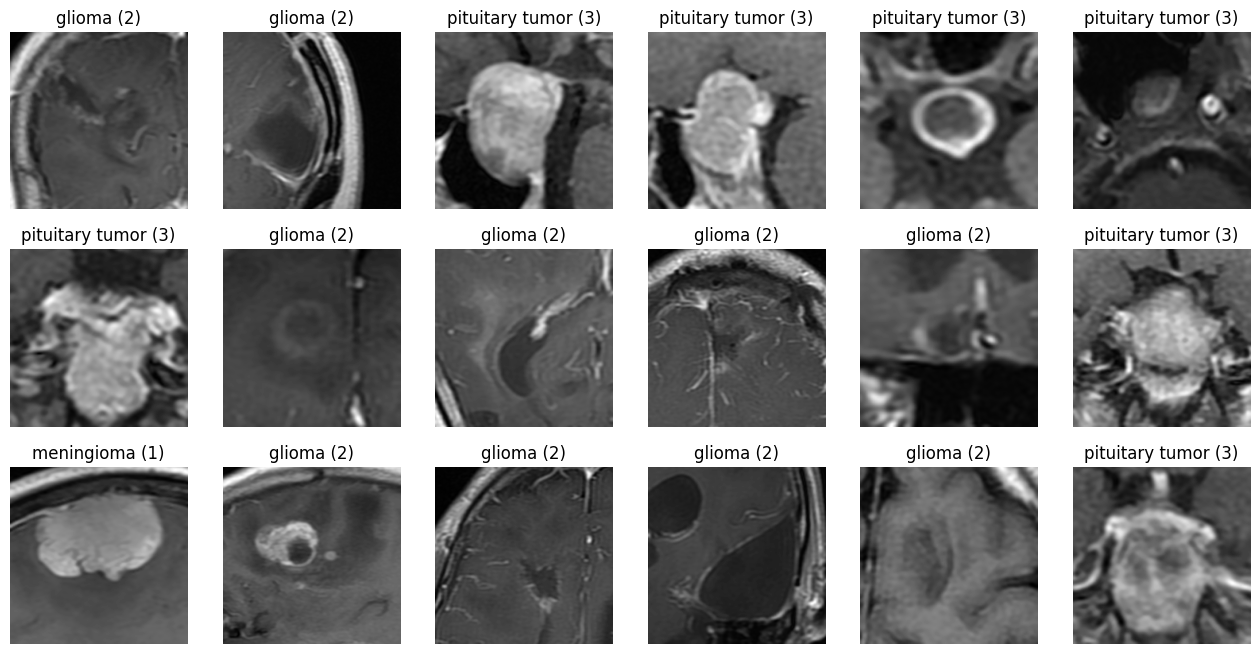

In [14]:
plt.figure(figsize=(16, 8))
for i, idx in enumerate(np.random.randint(images.shape[0], size=18), start=1):
    plt.subplot(3, 6, i)
    plt.imshow(images_cropped[idx], cmap='gray')
    plt.title(integer_to_class[str(labels[idx])])
    plt.axis('off')

# Splitting the data using subject-wise cross validation

In [18]:
# Each patient is limited to appearing in one fold. The number of distinct
# patients in each fold is apporximately the same
group_kfold = GroupKFold(n_splits=10)

# A list of lists, where each sublist represents the indices of one fold
folds = [indices for (_, indices) in group_kfold.split(file_paths, labels, patient_ids)]

# Take 2 folds for test, 2 for validation, 6 for training
def assign_folds_custom(iter=0):

  train_indices = np.array([], dtype=np.int16)
  val_indices = np.array([], dtype=np.int16)
  test_indices = np.array([], dtype=np.int16)

  i = iter * 2
  for _ in range(6):
    train_indices = np.append(train_indices, folds[i])
    i = (i + 1) % len(folds)


  for _ in range(2):
    val_indices = np.append(val_indices, folds[i])
    i = (i + 1) % len(folds)

  for _ in range(2):
    test_indices = np.append(test_indices, folds[i])
    i = (i + 1) % len(folds)

  print(train_indices)


  train_ds = tf.data.Dataset.from_tensor_slices((file_paths[train_indices], labels[train_indices]))
  val_ds = tf.data.Dataset.from_tensor_slices((file_paths[val_indices], labels[val_indices]))
  test_ds = tf.data.Dataset.from_tensor_slices((file_paths[test_indices], labels[test_indices]))

  return (train_ds, val_ds, test_ds)

train_ds, val_ds, test_ds = assign_folds_custom()



[   8   11   19 ... 3049 3052 3058]


In [ ]:
batch_size = 16 # Minibatch size
buffer_size= 64 # Sample mini-batches from a subset of the dataset


def read_image(path):
  img_shape=(512, 512)
  path_str = path.numpy().decode('UTF-8')
  image_data = images[np.where(file_paths == path_str)].reshape(img_shape)
  tensor = tf.convert_to_tensor(image_data)
  return tensor


def prepare(ds, shuffle=False, augment=False):
  """
    Prepare the dataset by:
      1) Applying a function to the dataset that will load and store <batch_size>
         images in memory at a time, to avoid exceeding RAM quota
      2) If augment=True, the dataset is augmented by performing a 90 deg
         rotation of each image and a flip along the horizontal axis.
  """

  # load images from disk only when needed, and
  ds = ds.map(lambda x, y: (tf.py_function(read_image, [x], [tf.int16]), y))
  ds = ds.map(lambda x, y: (tf.reshape(x, (512, 512, 1)), y))

  i = 0
  def augment(img):
    nonlocal i

    if i >= 2 * len(train_indices):
      image = tf.image.rot90(img)
    elif i >= len(train_indices):
      image = tf.image.flip_up_down(img)

    i += 1
    return img

  if augment:
    ds = ds.repeat(3)
    ds = ds.map(lambda x, y: (augment(x), y))

  if shuffle:
    ds = ds.shuffle(buffer_size)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size)
  return ds

train_ds = prepare(train_ds, shuffle=True, augment=True)
valid_ds = prepare(valid_ds, shuffle=True, augment=False)
test_ds = prepare(test_ds, shuffle=True, augment=False)

In [ ]:
num_classes = 3
def summarize_dataset(ds, name):

    count = np.zeros(num_classes, dtype=np.int32)
    for _, labels in ds:
      y, _, c = tf.unique_with_counts(labels)
      count[y.numpy()] += c.numpy()

    total = np.sum(count)

    label_stats = ""

    for (id_, label) in items(integer_to_class):
      label_stats += "{} {}\n".format(integer_to_class[id_], count[id_])

    print(f"Distribution of labels for {name}")
    print(label_stats)
    return

summarize_dataset(train_ds, "Training Dataset")
summarize_dataset(val_ds, "Valid Dataset")
summarize_dataset(test_ds, "Test Dataset")


# Model Implementation





In [ ]:
# Following structure of model detailed in paper:
# https://1drv.ms/u/s!AgLc-zP7ijxBkxNDdJDtxq4_xmt0

model = keras.Sequential()

### Pre-Processing Layer ###
model.add(keras.Input(shape=(512, 512, 1)))
model.add(keras.layers.Resizing(256, 256))
model.add(keras.layers.Rescaling(1./255))
model.summary()


### Classification Block A ###

# Layers 2 and 3
model.add(keras.layers.Conv2D(16, kernel_size=(5, 5), strides=(2, 2), padding='same', activation='relu'))
# Layer 4
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))




Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 256, 256, 1)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 256, 256, 1)       0         
                                                                 
Total params: 0 (0.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
